<a href="https://colab.research.google.com/github/Danayt09/Phase_5_Energy/blob/main/Modeling_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table Of Content
<a id='data_analysis'></a>
#### [1.Introduction](#Introduction)
#### [1.PreProcessing](#PreProcessing)
#### [2.Linear Analysis](#Stats.Model)
#### [3.Baseline Model](#BaselineModel)
#### [4.Timeseries Preprocessing](#TimeSerie)
#### [5.SARIMAX Model](#SARIMAX)
#### [6.SARIMAX with Weather](#SARIMAX_Weather_Variables)
#### [7.Random Forest with Lags](#RandomForest.Regressor)
#### [8.Regularized Regressor With Lags](#Regularized.Linear.Regression)
#### [9.Facebook's Prophet Model](#Prophet)
#### [10.Prophet with weather Variables](#Prophet.With.Weather)
#### [11.XGBoost With Lag Variables](#XGBoost)
#### [12.XGBoost with Fourier Terms](#XGBoost.With.Fourier)
#### [13.LSTM Model](#LSTM)

In [32]:
!pip install tensorflow scikit-learn
! pip install scikeras
! pip install pmdarima
! pip install plotly
! pip install sktime

In [121]:
from random import gauss as gs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 110)
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


import itertools
from pmdarima import auto_arima
import plotly.graph_objects as go
import statsmodels.api as sm

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from sklearn.base import BaseEstimator, TransformerMixin
from sktime.forecasting.naive import NaiveForecaster
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense
# from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
%matplotlib inline

import pickle
import joblib

import warnings
warnings.filterwarnings('ignore')
# warnings.WarningMessage('ignore')

# Introduction
This timeseries modeling notebooke will be focusing on predicting energy consumption by the hour for San Diego Gas and Energy Utility. The data used in this analysis was retrieved from [CAISO](http://www.caiso.com/planning/Pages/ReliabilityRequirements/Default.aspx), providing us with valuable insights into the energy consumption patterns in the region.
Extraction and merging with [weather](https://www.ncei.noaa.gov) data can be found in the [cleaning](https://github.com/Danayt09/Phase_5_Energy/blob/main/EnergyCleaning.ipynb) notebook.

Matching supply to demand is of utmost importance in the energy sector, it ensures the stability and reliability of power grid. Accurate predictions of energy consumption allow utility companies to effectively plan and allocate resources, optimize energy generation and distribution, and ultimately meet the demands of their customers. By leveraging advanced modeling techniques, this notebook aim's to develop accurate and reliable forecasts that can assist in achieving this goal.

To evaluate the performance of our models, we have employed several evaluation metrics. These metrics include Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and R-squared (R^2). These metrics provide us with a comprehensive understanding of the accuracy and precision of our predictions, enabling us to compare and select the best-performing model.

Throughout this notebook, we'll have explored various models to predict energy consumption. These models include SARIMAX, ELASTICNET, FBProphet, XGBoost, and LSTM. Each model brings its own strengths and characteristics, allowing us to capture different aspects of the underlying data patterns. By comparing the performance of these models, we can gain insights into which approach is most suitable for predicting energy consumption in this specific context.

In [ ]:
# !pip install sktime
# !pip install pmdarima

In [34]:
df = pd.read_csv('SDGE_W.csv')

In [35]:
# Dropping unnecessary columns and setting date as index
df = df.drop('Unnamed: 0', axis=1)
df.set_index("Date", inplace =True)
df.index = pd.to_datetime(df.index)

In [ ]:
df.head()

SDGE  year  month  day  hour  weekday  season  \
Date                                                                        
2019-01-01 00:00:00  2372.497411  2019      1    1     0  Tuesday  winter   
2019-01-01 01:00:00  2698.751137  2019      1    1     1  Tuesday  winter   
2019-01-01 02:00:00  2777.672120  2019      1    1     2  Tuesday  winter   
2019-01-01 03:00:00  2799.193829  2019      1    1     3  Tuesday  winter   
2019-01-01 04:00:00  2761.883322  2019      1    1     4  Tuesday  winter   

                     holiday  HourlyDryBulbTemperature  \
Date                                                     
2019-01-01 00:00:00        1                      49.0   
2019-01-01 01:00:00        0                      47.0   
2019-01-01 02:00:00        0                      47.0   
2019-01-01 03:00:00        0                      47.0   
2019-01-01 04:00:00        0                      46.5   

                     HourlyRelativeHumidity  HourlyWindSpeed  
Date                                                          
2019-01-01 00:00:00                    71.0              0.0  
2019-01-01 01:00:00                    77.0              5.0  
2019-01-01 02:00:00                    63.0              6.0  
2019-01-01 03:00:00                    52.0              6.0  
2019-01-01 04:00:00                    51.5              5.5

In [36]:
def train_val_test_split(df, validation=True):
    train_end = '2022-03-14 18:00:00'

    train_val = df.loc[:train_end, :]
    test_df = df.loc[train_end:, :]

    if not validation:
        return train_val, test_df

    n = len(train_val)
    cutoff = int(n*0.8)

    train_df = train_val[:cutoff]
    val_df = train_val[cutoff:]
    return train_df, val_df, test_df

In [37]:
def error_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    variance_score = r2_score(y_true, y_pred)
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")
    print(f"Variance Score: {variance_score:.2f}")

In [38]:
def plot_ts_pred(og_ts, pred_ts, model_name=None, og_ts_opacity = 0.5, pred_ts_opacity = 0.5):

    fig = go.Figure()

    fig.add_trace(go.Scatter(x = og_ts.index, y = np.array(og_ts.values), name = "Observed",
                         line_color = 'deepskyblue', opacity = og_ts_opacity))

    try:
        fig.add_trace(go.Scatter(x = pred_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))
    except: #if predicted values are a numpy array they won't have an index
        fig.add_trace(go.Scatter(x = og_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))


    #fig.add_trace(go)
    fig.update_layout(title_text = 'Observed vs Predicted energy MWH using {}'.format(model_name),
                  xaxis_rangeslider_visible = True)
    fig.show()

In [39]:
def record_results(model_name, train_results, test_results):
    new_row = {
        'Model': model_name,
        'Mean Absolute Error': train_results['Mean Absolute Error'],
        'Mean Squared Error': train_results['Mean Squared Error'],
        'Root Mean Squared Error': train_results['Root Mean Squared Error'],
        'Mean Absolute Percentage Error': train_results['Mean Absolute Percentage Error'],
        'Variance Score': train_results['Variance Score']
    }
    new_row_df = pd.DataFrame(new_row, index=[0])
    model_df = pd.concat([model_df, new_row_df], ignore_index=True)
    return model_df

# PreProcessing
>- Data has categorical and continuous features
>- We'll use the processor below for appropriate models that need preprocessing

In [94]:
cat_cols = ['year', 'month', 'hour', 'weekday', 'season', 'holiday']
num_cols = ['HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed']

In [95]:
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))

])
# Since we can't impute with mean we're using the constant imputing strategy to bfill, and the fill_value ensuring missing values are
#imputed with the next available value
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(add_indicator=True, strategy='constant', fill_value=None)),
    ('scaler', StandardScaler())
])

In [96]:
processes = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('num', numerical_transformer, num_cols)
    ], remainder='passthrough')

In [97]:
processes_num = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols)
    ], remainder='passthrough')

# Stats.Model
>- We'll check the goodness of fit with feature engineered columns from date_index and weather data
### Evaluation
>- The R-squared value 0.604, means that approximately 60.4% of the variation in the dependent variable, SDGE (energy consuption of Sandiego) can be explained by the independent variables in the model.
>- The adjusted R-squared value is 0.603, which takes into account the number of independent variables in the model. It is slightly lower than the R-squared value, suggesting that the additional independent variables may not be contributing much to the model's explanatory power.
>- The associated p-value is 0.00, indicating that the model is statistically significant.

In [ ]:
# Checking linear regression fit using statsmodels Linear regression
from statsmodels.formula.api import ols
m = ols('SDGE ~  C(year) + C(month) + C(day) +C(hour) + C(weekday) + C(season) + C(holiday) + \
                 HourlyDryBulbTemperature + HourlyRelativeHumidity + HourlyWindSpeed', df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                   SDGE   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     693.3
Date:                Tue, 14 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:07:00   Log-Likelihood:            -2.4719e+05
No. Observations:               35064   AIC:                         4.945e+05
Df Residuals:                   34986   BIC:                         4.952e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

# BaselineModel
## Persistent Forcast
Time series models are different from other continuous models because they take into account the temporal nature of the data. In time series analysis, the order and timing of the observations are important, and the goal is often to forecast future values based on past observations.

One key aspect of time series analysis is the consideration of time lags. Time lags refer to the use of previous observations as predictors for forecasting future values. By including lagged values as predictors we can capture the temporal dependencies and patterns in the data.

The persistent_forecast simple model below is created using time lags. It uses the np.tile() function to repeat the last 8760 values of the train_df['SDGE'] series multiple times, enough to cover the length of the test_df series. This ensures that the persistent_forecast has the same length as the test_df series. The [:len(test_df)] indexing is used to truncate the persistent_forecast to match the length of the test_df series.

By using the last 8760 values of the train_df['SDGE'] series as the persistent forecast, the code assumes that the future values will be similar to the most recent past values. This approach is often used as a simple baseline or benchmark for time series forecasting, where the forecast for each future point is simply the value of the corresponding lagged point.

### Model Results
Based on MAE on average, the predicted energy consumption values deviate from the true values by approximately 317.36 MW.

The MSE value of 185234.29 represents the average squared difference between the predicted and true energy consumption values. Since MSE is squared, it penalizes larger errors more heavily. In this case, the MSE suggests that the model's predictions have a relatively high level of error. The MSE provides a measure of the average magnitude of the errors in the same unit as the target variable.

The RMSE indicates that, on average, the predicted energy consumption values deviate from the true values by approximately 430.39 MW.

On average, the predicted values deviate from the true values by approximately 14.07%.

The variance score, also known as the coefficient of determination, measures the proportion of the variance in the target variable that can be explained by the model. A variance score of 0.29 indicates that the model explains approximately 29% of the variance in the energy consumption values. This suggests that there may be other factors or variables that are not captured by the model.

* Using this as a baseline i'll be opting to improve model performance

In [ ]:
df_hr = df[['SDGE']] # Using only target and index since I'll be using just time for the first simple model

In [ ]:
train_ts ,test_ts = train_val_test_split(df_hr, validation=False)

In [ ]:
# Creates the persistent forecast by repeating the values from last year
# The code below also repreats multiple times ensuring forcast has the same length as test data
#Finaling slicing the repeated data to match the test
persistent_forecast = np.tile(train_ts['SDGE'].values[-8760:], len(test_ts) // 8760 + 1)[:len(test_ts)]

In [ ]:
# Calculate the errors
y_true_pf = test_ts['SDGE']
y_pred_pf = persistent_forecast
error_metrics(y_true_pf, y_pred_pf)

Mean Absolute Error: 317.36
Mean Squared Error: 185234.29
Root Mean Squared Error: 430.39
Mean Absolute Percentage Error: 14.07%
Variance Score: 0.29


In [ ]:
plot_ts_pred(y_true_pf, y_pred_pf, model_name='Persistant Forcast', og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

# TimeSeriesPreprocessing


Time series prediction is different from traditional regression modeling because it takes into account the temporal aspect of the data. In a time series, the order and timing of observations matter, as there is a sequential dependency between data points. This sequential dependency can be attributed to various factors such as seasonality, trends, and autocorrelation.

To preprocess the time series data and extract meaningful features, we employed Fourier Transformation and STL (Seasonal and Trend decomposition using Loess) decomposition.

### Testing for stationarity
Based on the provided information, the test statistic is -8.697959e+00 and the p-value is 3.878533e-14.
If the p-value is less than the significance level (commonly 0.05), we reject the null hypothesis
and conclude that the time series is stationary.

In this case, the p-value (3.878533e-14) is much smaller than the significance level (0.05),
indicating strong evidence against the null hypothesis. We can therefore conclude that the time series is stationary.

In [ ]:
df_ad = df_hr[['SDGE']]

In [ ]:
ts_test = adfuller(df_ad)
display(ts_test)

(-8.697958813186991,
 3.8785331679432676e-14,
 52,
 35011,
 {'1%': -3.43053679213716,
  '5%': -2.8616225575095284,
  '10%': -2.566813942767471},
 475245.4656370086)

In [ ]:
# Extract and display test results in a user friendly manner
dfoutput = pd.Series(
                ts_test[0:4],
                index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
)

for key,value in ts_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value

display(dfoutput)

Test Statistic                -8.697959e+00
p-value                        3.878533e-14
#Lags Used                     5.200000e+01
Number of Observations Used    3.501100e+04
Critical Value (1%)           -3.430537e+00
Critical Value (5%)           -2.861623e+00
Critical Value (10%)          -2.566814e+00
dtype: float64

### Exponential Smoothing
Exponential smoothing is a time series forecasting method that assigns exponentially decreasing weights to past observations.

With an alpha value of 0.5, the model considers the most recent data point to be equally important as the previous forecast in predicting the future values.

The visual predicted values are close to the actual values, suggesting that the exponential smoothing model is capturing the underlying trend or pattern in the data reasonably well, smoothing out the noise or random fluctuations.

However Exponential smoothing is relatively a simple forcasting method and may fail to capture all complexities, we're also using just time as a variable without weather consideration. We'll explore other models to account for seasonality and fluctuations since our data has seasonal fluctuations on weekly and monthly bases.

The visualization was helpful in picking seasonal trends within hourly forcast that the decomposition method wasn't able to pick on.

In [ ]:
# Defining a function to plot exponentially smoothed data
def plot_ewma(ts, alpha):
    expw_ma = ts.ewm(alpha=alpha).mean()

    plot_ts_pred(ts, expw_ma, model_name='Exponentially smoothed data with alpha = {}'.format(alpha), \
                 og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

In [ ]:
# Plotting the exponentially smoothed energy consumption data with alpha=0.5
plot_ewma(df_hr['SDGE'], 0.5)

### Autocorrelation
Autocorrelation and partial autocorrelation are statistical measures used to analyze the relationship between observations in a time series data.

Autocorrelation (ACF):
Autocorrelation measures the linear relationship between an observation and its lagged values. It helps identify any patterns or dependencies in the data that are related to its past values. The autocorrelation function (ACF) is a plot that shows the correlation coefficient between the observations at different lags.

- If the ACF plot shows significant autocorrelation at multiple lags, it suggests the presence of a seasonal or cyclical pattern in the data.

Partial Autocorrelation (PACF):
Partial autocorrelation measures the direct relationship between an observation and its lagged values, while controlling for the intermediate lags. It helps identify the direct influence of past observations on the current observation, without the influence of the intermediate lags.

- If the PACF plot shows significant partial autocorrelation at multiple lags, it suggests the presence of a seasonal or cyclical pattern in the data.

#### Interpretation

As is identified above and further confirmed with these two plots, this time series has multiple seasonality and complex seasonality patterns. For this kind of time series, ARIMA (a common time series model) will not work very well.

Will try to decompose the time series with the STL method. The period is 24 * 7 hours because data has weekly seasonality from the EDA notebook. Of course, there are other seasonalities in this data, but the period mentioned above should demonstrate well this decomposition. And since this project is for energy trading purposes forcasts are usefull at longet a week in advance because of storage limitations and the fliuctuating nature of the market. Transmissions can't have too less or too much, leading to power shortage, inadequate heating, overloading damave, and voltage fluctuations. Energy storage is another shortcoming that makes the energy market viable fot a short term prediction.

In [ ]:
def acf_pacf_plots(ts, lags, figsize = (12,8)):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = figsize)

    # Plot the ACF of ts
    _ = plot_acf(ts, lags = lags, zero = False, ax = ax1, alpha = 0.05)

    # Plot the PACF of ts
    _ = plot_pacf(ts, lags = lags, zero = False, ax = ax2, alpha = 0.05)

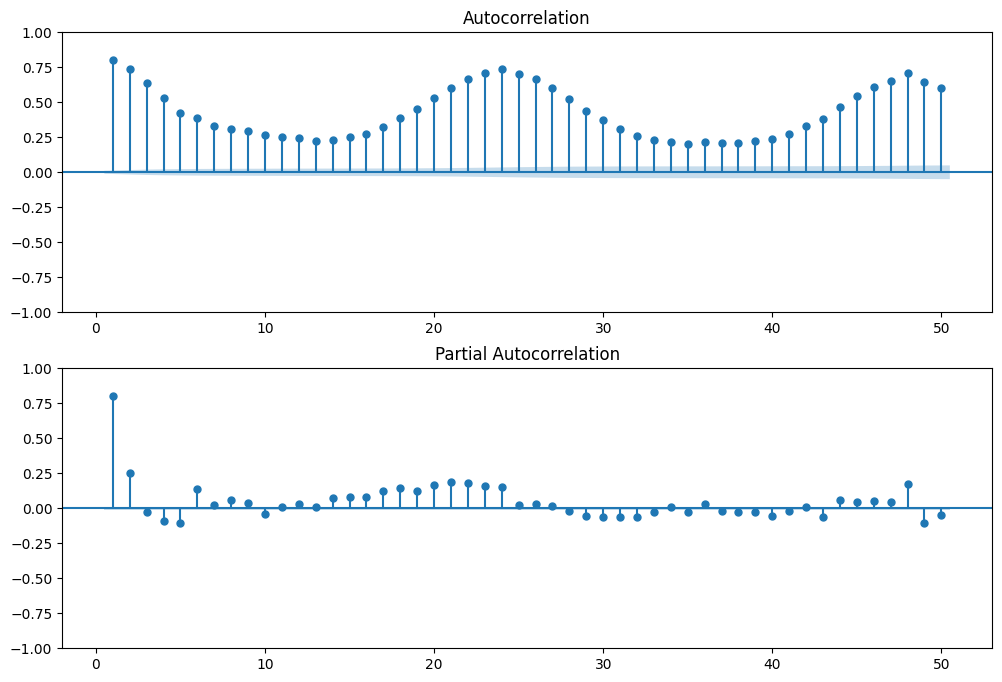

In [ ]:
# Create the acf and pacf plots

dfacf = []
dfacf = df_hr['SDGE']
lags = 50

acf_pacf_plots(dfacf, lags = lags, figsize = (12,8))

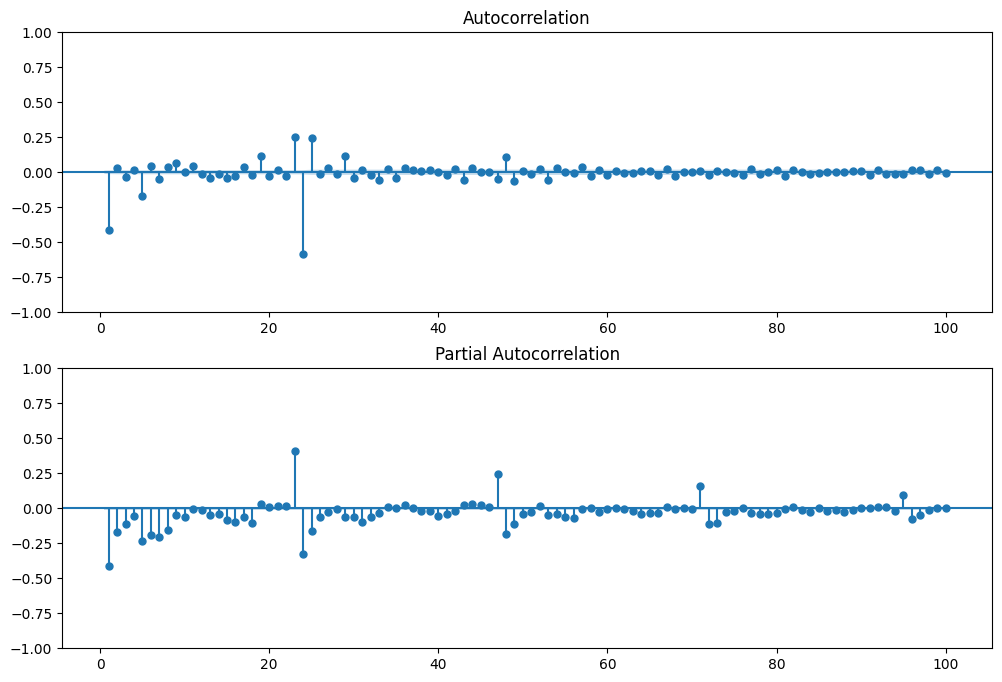

In [ ]:
# Differencing the data this time to remove the trend and seasonality
dfacf = []
dfacf = df_hr['SDGE']
dfacf = dfacf.diff().dropna() #Previous hour diff
dfacf = dfacf.diff(24).dropna() # Daily diff our value 24h
dfacf = dfacf.diff(24*365).dropna()#Yearly diff
lags = 100

acf_pacf_plots(dfacf, lags = lags, figsize = (12,8))

### STL Decomposition

STL decomposition is a method that decomposes a time series into three components: trend, seasonality, and remainder (residuals). The trend component captures the long-term changes or patterns in the data, while the seasonality component captures the repetitive patterns that occur within a specific time frame. The remainder component represents the random fluctuations or noise in the data. By decomposing the time series using STL, we can isolate and analyze each component separately, allowing us to better understand the underlying patterns and make more accurate predictions.

In previous notebook we tried the seaonal decomposition from statsmodel and it wasn't able to give us much insight when seen from a yearly prespective on seasonal fluctuation of the energy market. Here we're trying to use the STL decomposition, with a weekly period.

#### Interpretation
Now, we are pretty confident that the hourly electricity demand time series consists of three main components: A (yearly) trend that reaches bottom in July, a complex seasonality component (with multiple other seasonality sub-components), and holiday effects.

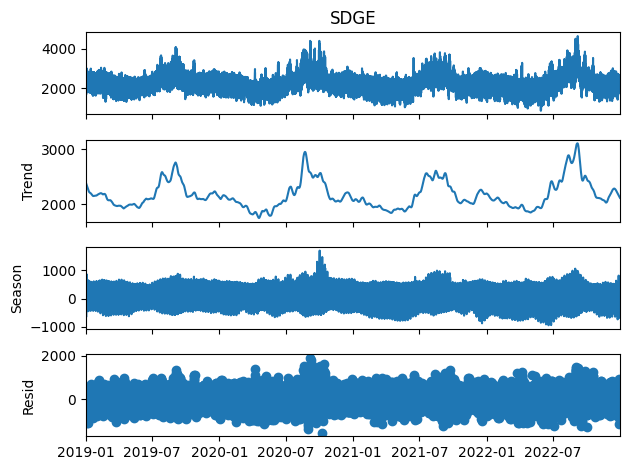

In [ ]:
stl = STL(df_hr.SDGE,period=24*7,robust=True)
res = stl.fit()
fig = res.plot()

In [ ]:
# We'll train and test SARIMAX with our data as it and use this to see if there's improvement
detrended = res.resid-res.trend
deseasonalized = res.resid -res.seasonal

# Time Series Modeling
## SARIMAX
Our SARIMAX model performed relatively well for a complex seasonality. with MAPE of 17.04%. The model has a mean absolute error (MAE) of 356.89 MWH. A lower MAE and MSE indicate better accuracy of the model in predicting the values. 356.89 MAE MWH is higher than our baseline model, since there's complex seasonal pattern in our data SARIMAX could be having a hard time picking on seasonal trends.

There's a solution for this and this [blog](https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a) goes in detail on forcasting timeseries with multiple seasoinality, because the other models mentioned are computationally expensive, we'll try the Fourier transformation method and engineer some features to help with seasonality modeling next.


In [ ]:
#Sarima parameters step serching to find a combination with minimum AIC

# p_values = range(0, 4)  # range of p values
# d_values = range(0, 4)  # range of d values
# q_values = range(0, 4)  # range of q values
# P_values = range(0, 4)  # range of seasonal P values
# D_values = range(0, 4)  # range of seasonal D values
# Q_values = range(0, 4)  # range of seasonal Q values
# m = 24  # seasonal period

# model = auto_arima(train_df, start_p=0, start_q=0,
#                    max_p=4, max_q=4, m=24,
#                    start_P=0, seasonal=True,
#                    d=1, D=1, trace=True,
#                    error_action='ignore',
#                    suppress_warnings=True,
#                    stepwise=True)
##Results
#order=(2,1,1)
#seasonal_order=(1, 0, 1, 24)

In [ ]:
# These were chosen from the above auto_arima search and chose the combination with the lowest AIC
sari_mod =SARIMAX(train_ts,
                  order=(2, 1, 1),
                  seasonal_order=(1, 0, 1, 24),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [ ]:
predictions = sari_mod.forecast(steps=len(test_ts))

In [ ]:
# Calculate the errors
y_true_sr = test_ts['SDGE']
y_pred_sr = predictions
error_metrics(y_true_sr, y_pred_sr)

Mean Absolute Error: 356.84
Mean Squared Error: 212099.74
Root Mean Squared Error: 460.54
Mean Absolute Percentage Error: 17.03%
Variance Score: 0.19


In [ ]:
plot_ts_pred(y_true_sr, y_pred_sr, model_name='SARIMAX', og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

# SARIMAX.Detrended

In [ ]:
det_size = int(len(detrended)*0.8)

In [ ]:
train_det = detrended[:det_size]
test_det = detrended[det_size:]

In [ ]:
# SARIMAX with our detrended data
sari_mod =SARIMAX(train_det,
                  order=(2, 1, 1),
                  seasonal_order=(1, 0, 1, 24),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [ ]:
predictions_trend = sari_mod.forecast(steps=len(test_det))

In [ ]:
# Calculate the errors
y_true_trend = test_det
y_pred_trend = predictions_trend
error_metrics(y_true_trend, y_pred_trend)

Mean Absolute Error: 413.03
Mean Squared Error: 281710.01
Root Mean Squared Error: 530.76
Mean Absolute Percentage Error: 17.02%
Variance Score: -1.03


In [ ]:
plot_ts_pred(y_true_trend, y_pred_trend, model_name='SARIMAX_Detrended', og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

# Sarimax with deseasonalized

In [ ]:
des_size = int(len(detrended)*0.8)
train_des = detrended[:des_size]
test_des = detrended[des_size:]

In [ ]:
# SARIMAX with our detrended data
sari_mod =SARIMAX(train_des,
                  order=(2, 1, 1),
                  seasonal_order=(1, 0, 1, 24),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [ ]:
predictions_deseasoned = sari_mod.forecast(steps=len(test_des))

In [ ]:
# Calculate the errors
y_true_des = test_des
y_pred_des = predictions_deseasoned
error_metrics(y_true_des, y_pred_des)

Mean Absolute Error: 413.03
Mean Squared Error: 281710.01
Root Mean Squared Error: 530.76
Mean Absolute Percentage Error: 17.02%
Variance Score: -1.03


###Interpretation
The SARIMAX model is performing the same on original data as well as the detrended and deseasonalized data, this could mean the trend and sesonality don't have much effect or are relatively weak or our model is not the best fit for the data, we'll try sarimax with weather variables next but from the above data ML aloriths such as linear models might be better suited. For SARIMAX we'll be trying a weekly forcasting model as it is more likely to pick on than than long term predictions as seen from the above models.

# SARIMAX_Weather_Variables

## Fourier Transformation

In a SARIMAX model, the Fourier transformation can be applied to capture and model the seasonal patterns of data. It is a mathematical technique used to decompose a time series into its constituent frequencies.

The Fourier transformation works by representing a time series as a sum of sine and cosine waves of different frequencies. These frequencies correspond to the different seasonal components present in the data, such as daily, weekly, or yearly patterns. By decomposing the time series into its frequency components, the Fourier transformation allows us to isolate and model the seasonal patterns separately.

We're using the Fourier Transformation to create additional exogenous variables that capture the seasonal patterns. These variables can improve the accuracy of the forecasts and capture the seasonal variations more effectively.

In [44]:
sdge = pd.read_csv('SDGE_W.csv')

In [45]:
sdge = sdge.drop('Unnamed: 0', axis=1)
sdge.set_index("Date", inplace =True)
sdge.index = pd.to_datetime(sdge.index)

In [46]:
sdge = sdge.drop(['season', 'weekday', 'month', 'year', 'hour', 'day'], axis=1)

In [47]:
sdge.head()

SDGE  holiday  HourlyDryBulbTemperature  \
Date                                                                  
2019-01-01 00:00:00  2372.497411        1                      49.0   
2019-01-01 01:00:00  2698.751137        0                      47.0   
2019-01-01 02:00:00  2777.672120        0                      47.0   
2019-01-01 03:00:00  2799.193829        0                      47.0   
2019-01-01 04:00:00  2761.883322        0                      46.5   

                     HourlyRelativeHumidity  HourlyWindSpeed  
Date                                                          
2019-01-01 00:00:00                    71.0              0.0  
2019-01-01 01:00:00                    77.0              5.0  
2019-01-01 02:00:00                    63.0              6.0  
2019-01-01 03:00:00                    52.0              6.0  
2019-01-01 04:00:00                    51.5              5.5

In [48]:
def add_fourier_terms(df, year_k, week_k, day_k):
    """df: dataframe to add the fourier terms to
    year_k: the number of Fourier terms the year period should have.
    Thus the model will be fit on 2*year_k terms (1 term for sine and 1 for cosine)
    week_k: same as year_k but for weekly periods
    day_k:same as year_k but for daily periods """
    for k in range(1, year_k+1):         # year has a period of 365.25 including the leap year
        df['year_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofyear/365.25)
        df['year_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofyear/365.25)
    for k in range(1, week_k+1):         # week has a period of 7
        df['week_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofweek/7)
        df['week_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofweek/7)
    for k in range(1, day_k+1):         # day has period of 24
        df['hour_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.hour/24)
        df['hour_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.hour/24)  # Create Fourier terms for weekly seasonality

In [49]:
add_fourier_terms(sdge, year_k= 5, week_k=5, day_k=5)

In [50]:
train_fr ,test_fr = train_val_test_split(sdge, validation=False)

In [51]:
# One week prediction
X_to_train = sdge.iloc[:(len(sdge) - 7*24)].drop('SDGE',axis=1)
X_to_test = sdge.iloc[(len(sdge) - 7*24):].drop('SDGE',axis=1)
y_to_train = sdge.iloc[:(len(sdge)-7*24)]['SDGE']
y_to_test = sdge.iloc[(len(sdge)-7*24):]['SDGE']

In [ ]:
# X_train_fr = train_fr.drop('SDGE', axis= 1)
# y_train_fr = train_fr.SDGE
# X_test_fr = test_fr.drop('SDGE', axis= 1)
# y_test_fr = test_fr.SDGE

In [52]:
scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_to_train)
X_test_processed = scaler.transform(X_to_test)

In [53]:
sari_fr = SARIMAX(y_to_train,
                  order=(3, 1, 1),
                  seasonal_order=(1, 0, 1, 24),
                  enforce_stationarity=False,
                  enforce_invertibility=False,
                exog = X_train_processed).fit(n_jobs=-1)

In [54]:
y_pred_fr = sari_fr.predict(start=len(y_to_train), end=len(y_to_train)+len(y_to_test)-1, exog=X_test_processed)

In [55]:
# Calculate the errors
error_metrics(y_to_test,  y_pred_fr)

Mean Absolute Error: 278.59
Mean Squared Error: 121940.94
Root Mean Squared Error: 349.20
Mean Absolute Percentage Error: 12.86%
Variance Score: -0.64


In [58]:
plot_ts_pred(y_to_test, y_pred_fr, model_name='SARIMAX Week Ahead Prediction', og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

#### Interpretation
The SARIMAX model performed much better than the initial data for weekly prediction as data has multiple seasonal componenents that the model is having a hard time to pick. Using historical data SARIMAX can only predict a week ahead at most with reduced error persontage from 17% to 12%.

# Linear_Models
# RandomForest.Regressor
Linear regression models can be used to predict hourly energy consumption by incorporating feature engineered lags. We can create lag variables by shifting the original weather data by a certain number of hours.

To predict hourly energy consumption using 24-hour lags, we would create 24 lag variables for each historical hourly consumption

Once we have created the lag variables, we can use them as input features in a linear regression model. The model will learn the relationship between the lagged features and the target variable (hourly consumption) based on the training data. The coefficients of the lag variables in the linear regression equation will indicate the impact of each lagged feature on the predicted energy consumption.

When making predictions for future hours, we would use the lagged weather features from the previous day as inputs to the model. For example, if we want to predict the weather at 2 PM today, we would use the lagged weather features from 2 PM to 2 PM of the previous day as inputs to the model.

In [99]:
df_lr = pd.read_csv('SDGE_W.csv')

In [100]:
df_lag = df_lr.copy()

In [101]:
# Creating the lag variables
for i in range(24):
    df_lag['lag'+str(i+1)] = df_lag['SDGE'].shift(i+1)

In [102]:
# Since the first 24 values won't have any 24th lag, they will be null values, therefore dropping them
df_lag = df_lag.dropna()

In [103]:
df_lag = df_lag.drop(['day'], axis=1)

In [104]:
df_lag = df_lag.drop('Unnamed: 0', axis=1)
df_lag.set_index("Date", inplace =True)
df_lag.index = pd.to_datetime(df_lag.index)

In [105]:
train_lag, test_lag = train_val_test_split(df_lag, validation=False)

In [106]:
cv = TimeSeriesSplit(n_splits=5)

In [107]:
X_train_lag = train_lag.drop('SDGE', axis = 1)
y_train_lag = train_lag.SDGE
X_test_lag = test_lag.drop('SDGE', axis = 1)
y_test_lag = test_lag.SDGE

In [113]:
param_rf = {
        'rf__n_estimators': [10, 50, 70, 100, 120, 140, 170, 200],
        'rf__max_depth': [2, 3, 4, 5, 7, 9, 10],
        'rf__max_features' : ['auto', 'sqrt'],
        'rf__min_samples_split': [2, 5, 7, 10]
}

In [114]:
#Create pipeline
RandomForest = Pipeline([
    ('processes', processes),
    ('rf', RandomForestRegressor())
])

In [115]:
rflag = GridSearchCV(estimator = RandomForest, param_grid= param_rf,
                               cv = cv, verbose=2, n_jobs = -1)

In [116]:
rflag.fit(X_train_lag, y_train_lag)

Fitting 5 folds for each of 448 candidates, totalling 2240 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('processes',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['year',
                                                                          'month',
                                                                          'hour',
                                                                          'weekday',
                                                                          'season',
                                                                          'holiday']),
                                                                        ('num',
                                                                         Pipeline(steps=[('im...
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['HourlyDryBulbTemperature',
                                                                          'HourlyRelativeHumidity',
                                                                          'HourlyWindSpeed'])])),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [2, 3, 4, 5, 7, 9, 10],
                         'rf__max_features': ['auto', 'sqrt'],
                         'rf__min_samples_split': [2, 5, 7, 10],
                         'rf__n_estimators': [10, 50, 70, 100, 120, 140, 170,
                                              200]},
             verbose=2)

In [117]:
best_rf_params = rflag.best_params_
rf_model = rflag.best_estimator_

In [118]:
y_pred_rf = rf_model.predict(X_test_lag)

In [ ]:
y_pred_rf_tr = rf_model.predict(X_train_lag)
error_metrics(y_train_lag,  y_pred_rf_tr)

In [119]:
error_metrics(y_test_lag,  y_pred_rf)

Mean Absolute Error: 154.48
Mean Squared Error: 46361.25
Root Mean Squared Error: 215.32
Mean Absolute Percentage Error: 7.25%
Variance Score: 0.82


In [120]:
plot_ts_pred(y_test_lag, y_pred_rf, model_name='RandomForest', og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

In [122]:
filename = 'RandomForestRegressor.pkl'

In [123]:
with open (filename,'wb') as file:
  pickle.dump(rf_model, file)

# Regularized.Linear.Regression

Since we're using laggs to model, our data is highly multicolinear
Ridge, Lasso or Elastic net are great models that can deal with such data:

Ridge regression is a regularized linear regression model that adds a penalty term to the loss function to shrink the coefficients towards zero, reducing the impact of highly correlated features. This is effective with a large number of lagged features to avoid overfitting.

Lasso regression is another regularized linear regression model that can handle multicollinearity. The penalty term encourages sparsity in the coefficients, effectively selecting a subset of the lagged features. Lasso regression is usefull to identify the most important lagged features for predicting the target variable.

Elastic net regression is a combination of ridge and lasso regression that balances between the two regularization techniques. It adds both L1 and L2 penalties to the loss function, allowing for both feature selection and coefficient shrinkage. Elastic net regression is effective to balance between selecting important lagged features and reducing multicollinearity.

We'll try Elastic net regression with our lagged data for hourly prediction and see how it performs.

In [138]:
from sklearn.linear_model import ElasticNet

In [139]:
param_en = {
    'en__alpha': [0.1, 0.5, 1.0],
    'en__l1_ratio': [0.2, 0.5, 0.8]
}

In [140]:
#Create pipeline
ElasticNet = Pipeline([
    ('processes', processes),
    ('en', ElasticNet())
])

In [141]:
en_model = GridSearchCV(estimator = ElasticNet, param_grid= param_en,
                               cv = cv, verbose=2, n_jobs = -1)

In [142]:
en_model.fit(X_train_lag, y_train_lag)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('processes',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['year',
                                                                          'month',
                                                                          'hour',
                                                                          'weekday',
                                                                          'season',
                                                                          'holiday']),
                                                                        ('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['HourlyDryBulbTemperature',
                                                                          'HourlyRelativeHumidity',
                                                                          'HourlyWindSpeed'])])),
                                       ('en', ElasticNet())]),
             n_jobs=-1,
             param_grid={'en__alpha': [0.1, 0.5, 1.0],
                         'en__l1_ratio': [0.2, 0.5, 0.8]},
             verbose=2)

In [143]:
best_en_params = en_model.best_params_
en_model = en_model.best_estimator_

In [144]:
best_en_params

{'en__alpha': 0.1, 'en__l1_ratio': 0.8}

In [145]:
y_pred_en = en_model.predict(X_test_lag)

In [146]:
error_metrics(y_test_lag,  y_pred_en)

Mean Absolute Error: 176.29
Mean Squared Error: 56385.76
Root Mean Squared Error: 237.46
Mean Absolute Percentage Error: 8.39%
Variance Score: 0.78


In [147]:
plot_ts_pred(y_test_lag, y_pred_en, model_name='Elastic Net', og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

#### Linear Model's Interpretation
Using a 24hour lag variables both Random Forest and Elastic Net performed well.
With Random forest persorming slightly better than Elastic net, the model was on average off the actual energy consumption by  170.53 MWH hourly. That's at 8.09% error with about 0.80 of the variables explaining the change in consumption which is pretty high.

# FB Prophet
Prophet is a time series forecasting library developed by Facebook. It is designed to provide accurate and intuitive forecasts for time series data with various trends and seasonal patterns. Prophet uses a decomposable model that consists of three main components: trend, seasonality, and holidays. The trend component captures the long-term growth or decline in the data, while the seasonality component captures recurring patterns such as daily, weekly, or yearly seasonality. The holiday component allows for the inclusion of specific events or holidays that may impact the data.

Prophet uses a Bayesian approach to fit the model to the data, allowing for uncertainty estimation and the incorporation of prior knowledge.
We'll first try prophet model without any betterment and add information based on resuts.

In [152]:
# Facebook Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric, plot_seasonality
import prophet.plot

In [ ]:
# !pip install prophet

In [126]:
sdge_data = pd.read_csv('SDGE_W.csv')

In [ ]:
sdge_fb = sdge_data[["Date", "SDGE"]]

In [ ]:
sdge_fb.rename(columns={'Date':'ds','SDGE':'y'}, inplace =True)

In [ ]:
sdge_fb.head()

In [ ]:
train_fb, test_fb = train_val_test_split(sdge_fb, validation=False)

In [ ]:
prophet = Prophet(interval_width=0.95)  # for each estimate, return a 95% interval
prophet.fit(train_fb)

In [ ]:
future = prophet.make_future_dataframe(periods=len(test_fb), freq='H')
forecast = prophet.predict(future)

In [ ]:
prophet.plot(forecast)

In [ ]:
prophet.plot_components(forecast)

In [ ]:
y = test_fb['y']
yhat = forecast['yhat'].tail(len(test_fb))

In [ ]:
error_metrics(y, yhat)

In [ ]:
plot_ts_pred(y, yhat, model_name='FB Prophet', og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

### Interpretation
Late summer and early autumn are typically the hottest times of the year in sandiego, which prophet seems to capture, weekdays are also prone to more consumption as work hours, the yearly trend in consuption has relatively been constant but we're interested in predicting hourly consumption and we'll skip this for now.

We'll include weather data, and see if model improves.

From the error metrics we can see that the model perfoms much better than our baseline model even without any additional information. The predicted energy consumption is on avegage 255.00 MWH off from the actual value, which is a mean error of 11.51%.

# FB_Weather

In [ ]:
# Create afternoon, evenin variables
#weekend seems to have low consumption, we'll group it with holidays and create a non working column

In [127]:
sdge_data.head()

Unnamed: 0                 Date         SDGE  year  month  day  hour  \
0           0  2019-01-01 00:00:00  2372.497411  2019      1    1     0   
1           1  2019-01-01 01:00:00  2698.751137  2019      1    1     1   
2           2  2019-01-01 02:00:00  2777.672120  2019      1    1     2   
3           3  2019-01-01 03:00:00  2799.193829  2019      1    1     3   
4           4  2019-01-01 04:00:00  2761.883322  2019      1    1     4   

   weekday  season  holiday  HourlyDryBulbTemperature  HourlyRelativeHumidity  \
0  Tuesday  winter        1                      49.0                    71.0   
1  Tuesday  winter        0                      47.0                    77.0   
2  Tuesday  winter        0                      47.0                    63.0   
3  Tuesday  winter        0                      47.0                    52.0   
4  Tuesday  winter        0                      46.5                    51.5   

   HourlyWindSpeed  
0              0.0  
1              5.0  
2              6.0  
3              6.0  
4              5.5

In [128]:
#adding in another column which indicates 'non-working' days which include weekends and holidays
sdge_data['non_working'] = sdge_data.apply(lambda x: 'non-working' if \
                                         ((x['holiday'] == 1) or (x['weekday'] in ['Saturday', 'Sunday']))
                                         else 'working', axis = 1)

In [129]:
sdge_data.head(1)

Unnamed: 0                 Date         SDGE  year  month  day  hour  \
0           0  2019-01-01 00:00:00  2372.497411  2019      1    1     0   

   weekday  season  holiday  HourlyDryBulbTemperature  HourlyRelativeHumidity  \
0  Tuesday  winter        1                      49.0                    71.0   

   HourlyWindSpeed  non_working  
0              0.0  non-working

In [130]:
sdge_tr = sdge_data[['Date', 'SDGE','HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed','non_working']]

In [131]:
sdge_tr['non_working'] = sdge_tr['non_working'].astype('category')

In [132]:
sdge_tr = pd.get_dummies(sdge_tr, columns=['non_working'])

In [133]:
sdge_tr.head()

Date         SDGE  HourlyDryBulbTemperature  \
0  2019-01-01 00:00:00  2372.497411                      49.0   
1  2019-01-01 01:00:00  2698.751137                      47.0   
2  2019-01-01 02:00:00  2777.672120                      47.0   
3  2019-01-01 03:00:00  2799.193829                      47.0   
4  2019-01-01 04:00:00  2761.883322                      46.5   

   HourlyRelativeHumidity  HourlyWindSpeed  non_working_non-working  \
0                    71.0              0.0                        1   
1                    77.0              5.0                        0   
2                    63.0              6.0                        0   
3                    52.0              6.0                        0   
4                    51.5              5.5                        0   

   non_working_working  
0                    0  
1                    1  
2                    1  
3                    1  
4                    1

In [134]:
sdge_tr.rename(columns={'Date':'ds','SDGE':'y'}, inplace =True)

In [135]:
train_tr, test_tr = train_val_test_split(sdge_tr, validation=False)

In [153]:
# Create a new Prophet model
pro_lr = Prophet(growth='linear', interval_width = 0.95,
               daily_seasonality=False)

# Add the regressor variables to the model
pro_lr.add_regressor('HourlyDryBulbTemperature', prior_scale=20, mode='additive', standardize=True)
pro_lr.add_regressor('HourlyRelativeHumidity', prior_scale=10, mode='additive', standardize=True)
pro_lr.add_regressor('HourlyWindSpeed',prior_scale = 10, mode='additive', standardize=True )
pro_lr.add_regressor('non_working_non-working',prior_scale = 10, mode='additive', standardize='auto' )
pro_lr.add_regressor('non_working_working', prior_scale=10, mode='additive', standardize='auto')

# Adding daily seasonality
pro_lr.add_seasonality(name= 'monthly', period =30.5, fourier_order = 12)
pro_lr.add_seasonality(name='daily', period = 1, fourier_order = 15, prior_scale=20)
pro_lr.add_seasonality(name = "weekly", period = 7, fourier_order=20)
pro_lr.add_seasonality(name = "quarterly", period = 365.25/4 ,fourier_order=4, prior_scale = 15)

In [154]:
# Fit the model to the data
pro_lr.fit(train_tr)

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4z73j1n_/bcorknvd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4z73j1n_/mkm5kukb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23949', 'data', 'file=/tmp/tmp4z73j1n_/bcorknvd.json', 'init=/tmp/tmp4z73j1n_/mkm5kukb.json', 'output', 'file=/tmp/tmp4z73j1n_/prophet_model54iyid4x/prophet_model-20231115005321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:53:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:53:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [155]:
future = pro_lr.make_future_dataframe(periods=len(test_tr), freq='H')

In [156]:
regressor_values = pd.concat([train_tr, test_tr])

In [157]:
regressor_values = regressor_values.drop('y', axis =1)

In [158]:
regressor_values['ds'] = pd.to_datetime(regressor_values['ds'])

In [159]:
# Adding regressor inputs for future predictions prophet model
future = pd.merge(future, regressor_values, on = 'ds')

In [160]:
future.head()

ds  HourlyDryBulbTemperature  HourlyRelativeHumidity  \
0 2019-01-01 00:00:00                      49.0                    71.0   
1 2019-01-01 01:00:00                      47.0                    77.0   
2 2019-01-01 02:00:00                      47.0                    63.0   
3 2019-01-01 03:00:00                      47.0                    52.0   
4 2019-01-01 04:00:00                      46.5                    51.5   

   HourlyWindSpeed  non_working_non-working  non_working_working  
0              0.0                        1                    0  
1              5.0                        0                    1  
2              6.0                        0                    1  
3              6.0                        0                    1  
4              5.5                        0                    1

In [161]:
# Make predictions
forcast = pro_lr.predict(future)

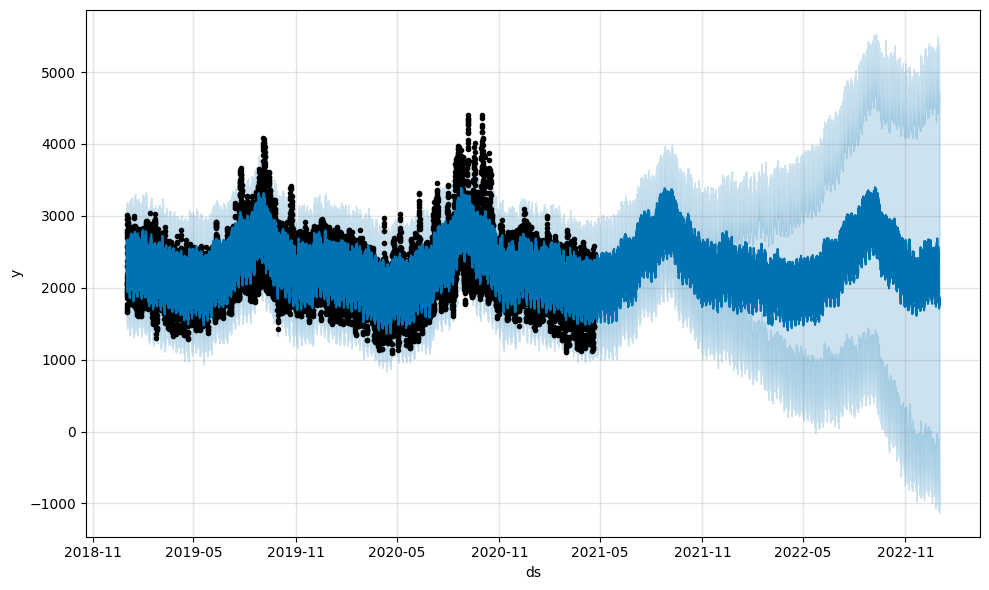

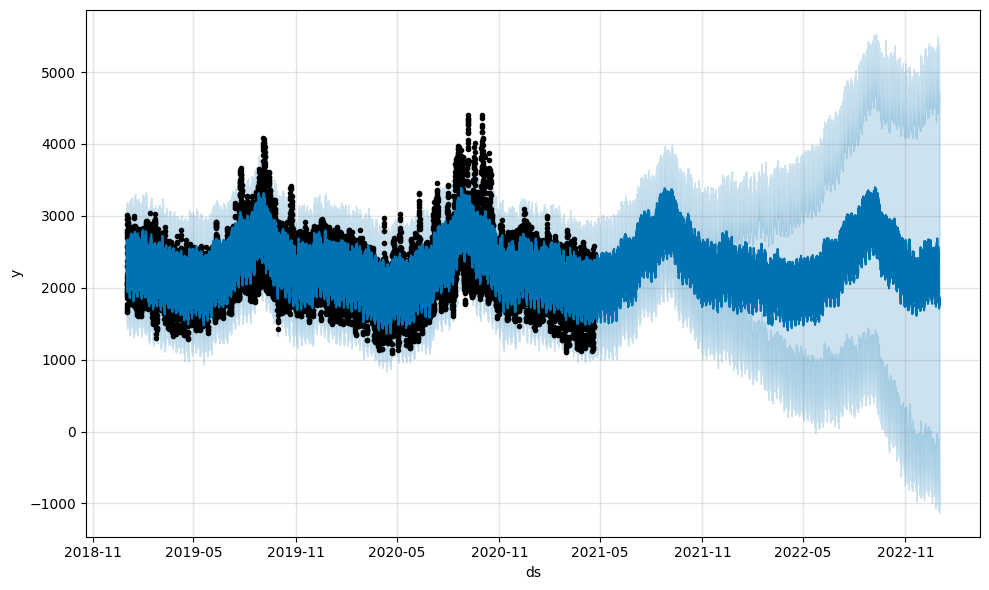

In [162]:
pro_lr.plot(forcast)

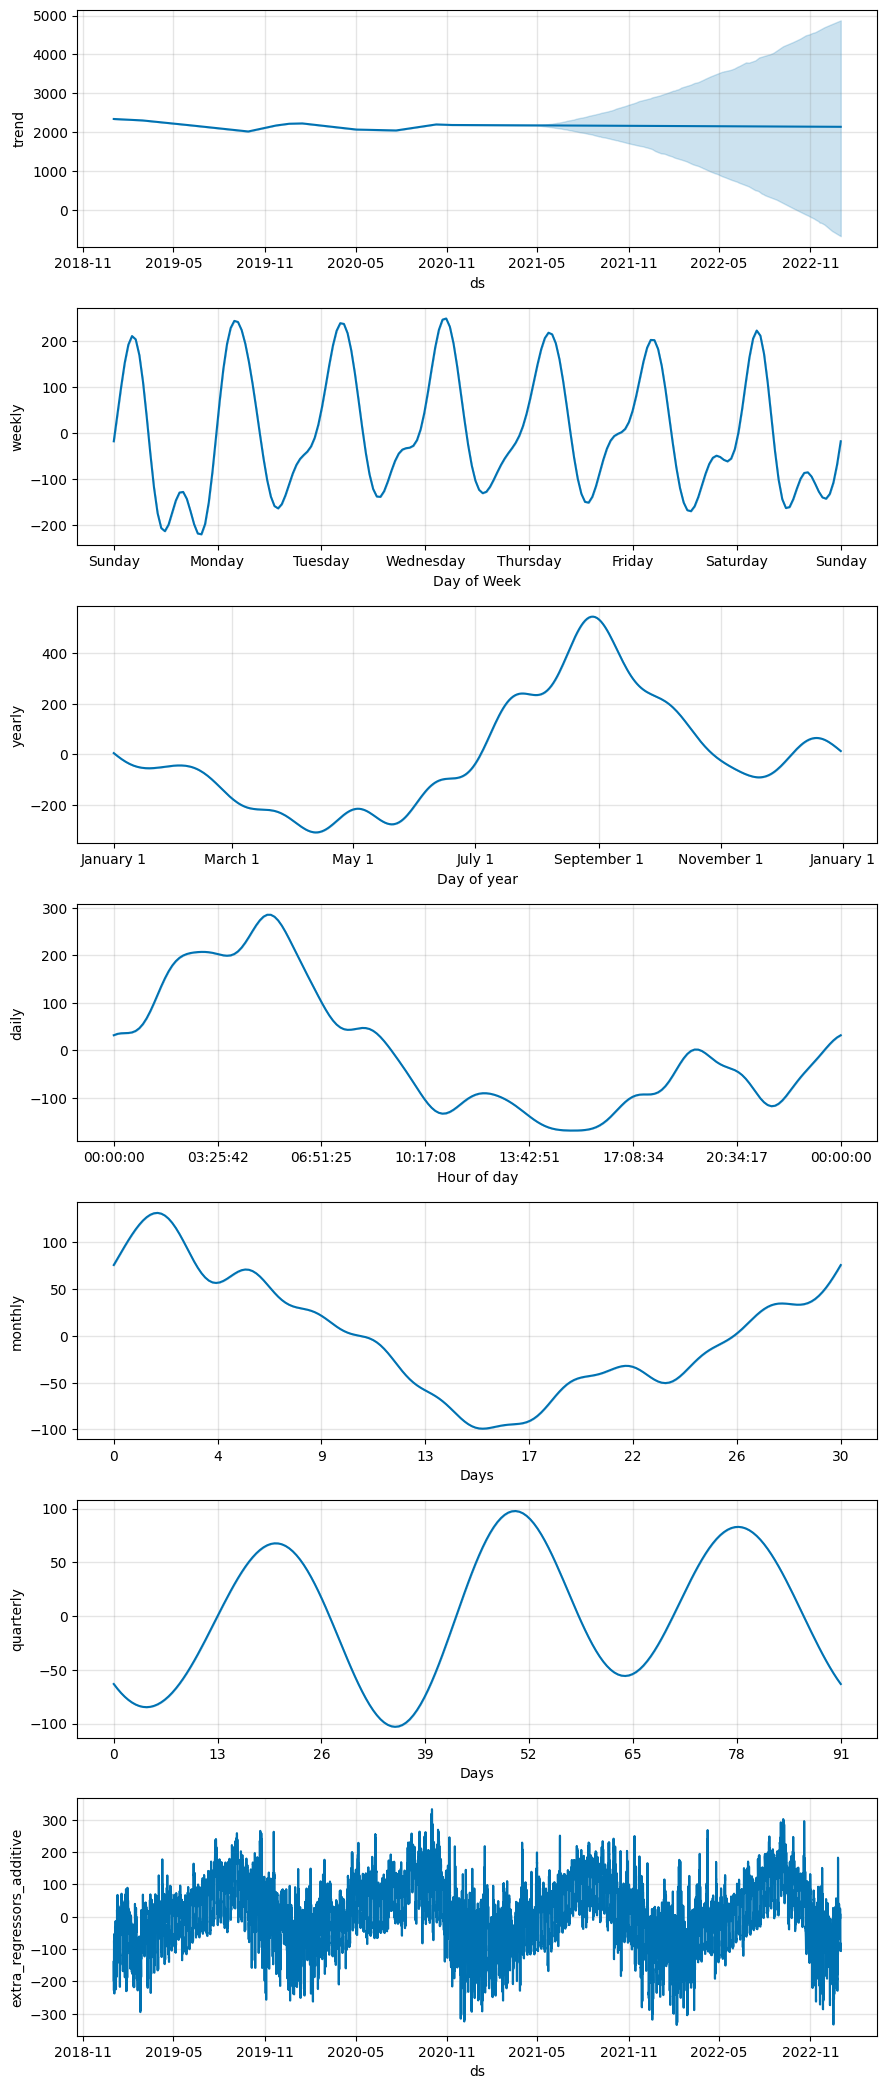

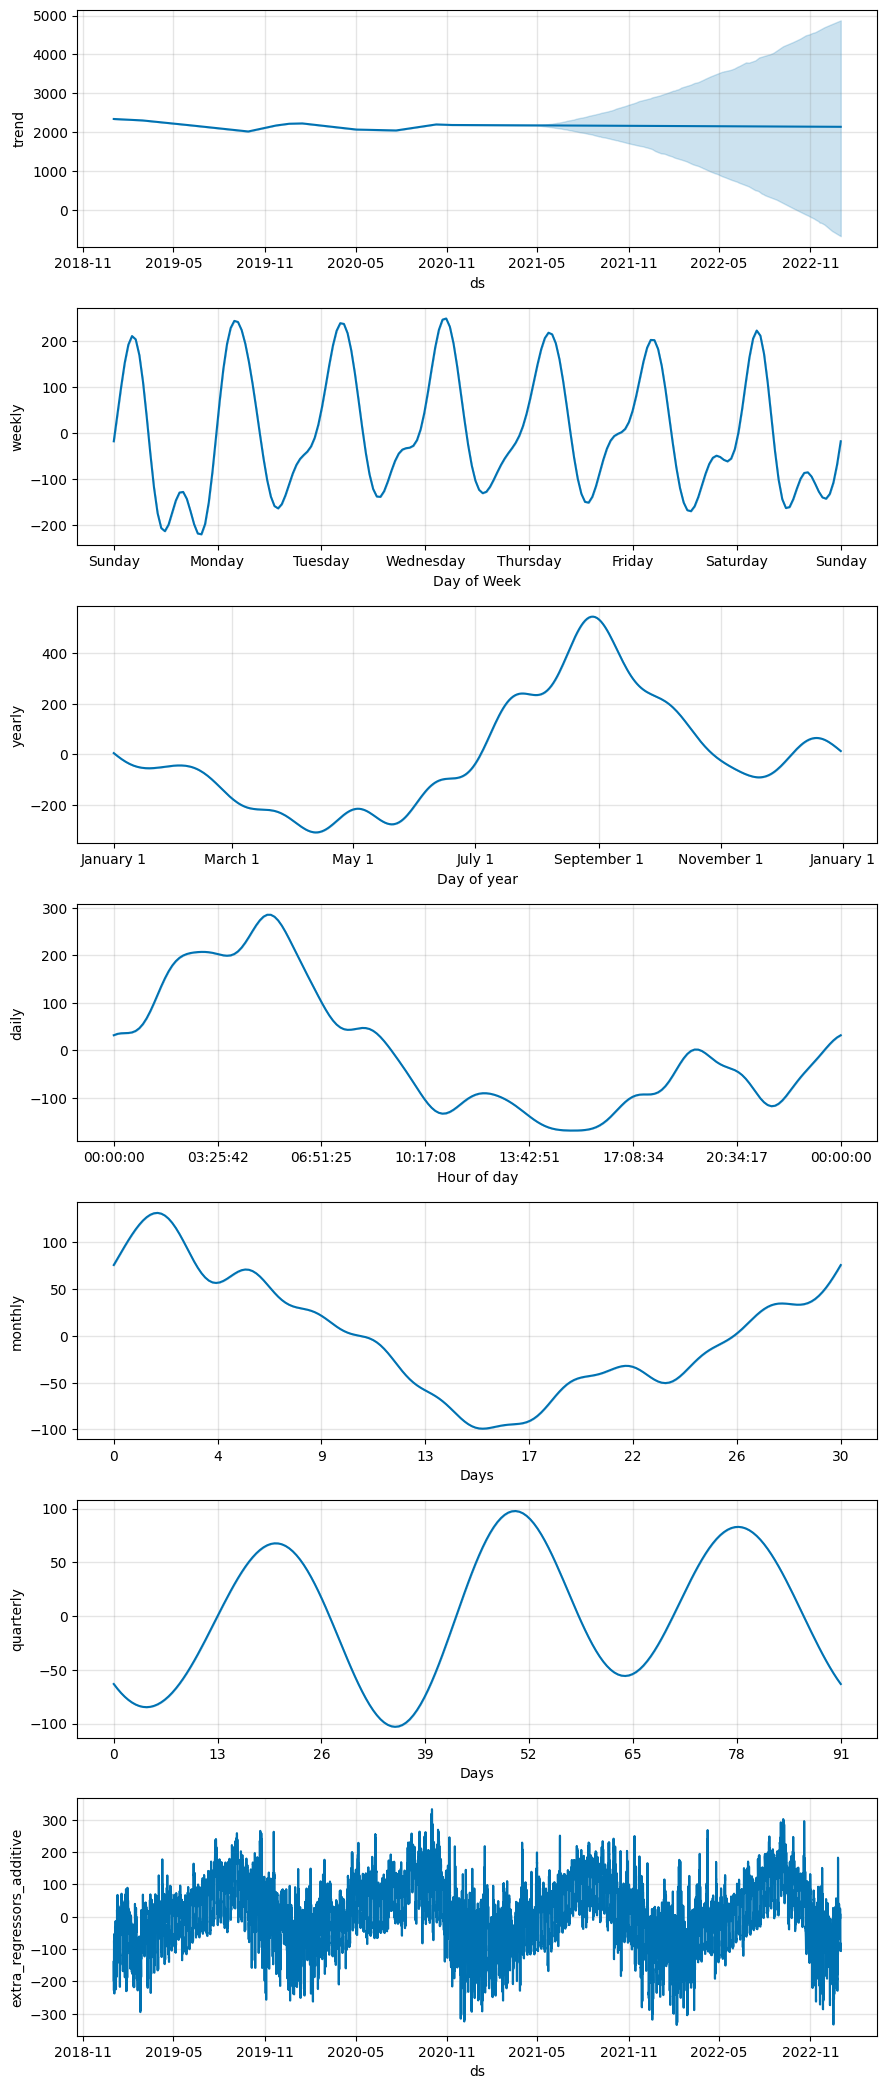

In [163]:
pro_lr.plot_components(forcast)

In [164]:
y_tr = train_tr['y']
yhat_tr = forcast['yhat'].tail(len(train_tr))

In [165]:
#Train evaluation
error_metrics(y_tr, yhat_tr)

Mean Absolute Error: 513.13
Mean Squared Error: 418840.02
Root Mean Squared Error: 647.18
Mean Absolute Percentage Error: 9.49%
Variance Score: -1.29


In [166]:
y_pr = test_tr['y']
yhat_pr = forcast['yhat'].tail(len(test_tr))

In [167]:
#Test set Evaluation
error_metrics(y_pr, yhat_pr)

Mean Absolute Error: 222.14
Mean Squared Error: 85348.87
Root Mean Squared Error: 292.15
Mean Absolute Percentage Error: 10.39%
Variance Score: 0.60


In [168]:
plot_ts_pred(y_pr, yhat_pr, model_name='FB Prophet+regressor', og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

#### Interpretation
The model's performance increased and the error percentage decreased with additional regressor variables such as weather and daytime classification but from the component breakdown we can see that the enegy consumption of the region is still high at night and not day of evening. The model's MAPE got to 10.40% from 11.51% and variance score also increased from 0.48 to 0.60 which isn't bad. But since this project is for hourly prediction linear regression models above performed better than prophet, we'll try xgboost next since random forest so far has the smallest error margin compared to other models we've run.

This was during covid times, consumption during night makes sence as a lot of companies were shut down and most people worked from home.

# XGBoosting

In [255]:
import xgboost as xgb

In [286]:
xg_params = {
    'eta':[0.1,0.001,0.001],
    'max_depth':[3,5,7],
    'n_estimator': [100,200,300],
    'colsample_bytree':[0.1, 0.3,0.5,0.7]

}

In [287]:
# generating the model
xg_reg = xgb.XGBRegressor(objective ='reg:linear')

In [288]:
xg_data = df_lag.copy()
xg_data.head()

SDGE  year  month  hour    weekday  season  \
Date                                                                     
2019-01-02 00:00:00  2485.555484  2019      1     0  Wednesday  winter   
2019-01-02 01:00:00  2721.290944  2019      1     1  Wednesday  winter   
2019-01-02 02:00:00  2892.607242  2019      1     2  Wednesday  winter   
2019-01-02 03:00:00  2959.789468  2019      1     3  Wednesday  winter   
2019-01-02 04:00:00  3012.999287  2019      1     4  Wednesday  winter   

                     holiday  HourlyDryBulbTemperature  \
Date                                                     
2019-01-02 00:00:00        0                      49.0   
2019-01-02 01:00:00        0                      46.0   
2019-01-02 02:00:00        0                      46.0   
2019-01-02 03:00:00        0                      43.0   
2019-01-02 04:00:00        0                      42.5   

                     HourlyRelativeHumidity  HourlyWindSpeed         lag1  \
Date                                                                        
2019-01-02 00:00:00                    21.0              6.0  2060.561258   
2019-01-02 01:00:00                    26.0              0.0  2485.555484   
2019-01-02 02:00:00                    27.0              0.0  2721.290944   
2019-01-02 03:00:00                    35.0              7.0  2892.607242   
2019-01-02 04:00:00                    36.5              3.5  2959.789468   

                            lag2         lag3         lag4         lag5  \
Date                                                                      
2019-01-02 00:00:00  1898.794915  2040.643947  2059.579137  1969.964879   
2019-01-02 01:00:00  2060.561258  1898.794915  2040.643947  2059.579137   
2019-01-02 02:00:00  2485.555484  2060.561258  1898.794915  2040.643947   
2019-01-02 03:00:00  2721.290944  2485.555484  2060.561258  1898.794915   
2019-01-02 04:00:00  2892.607242  2721.290944  2485.555484  2060.561258   

                            lag6         lag7         lag8         lag9  \
Date                                                                      
2019-01-02 00:00:00  2582.693431  1891.808751  1934.057172  1998.915397   
2019-01-02 01:00:00  1969.964879  2582.693431  1891.808751  1934.057172   
2019-01-02 02:00:00  2059.579137  1969.964879  2582.693431  1891.808751   
2019-01-02 03:00:00  2040.643947  2059.579137  1969.964879  2582.693431   
2019-01-02 04:00:00  1898.794915  2040.643947  2059.579137  1969.964879   

                           lag10        lag11        lag12        lag13  \
Date                                                                      
2019-01-02 00:00:00  2088.453772  1858.500053  1937.755534  1779.382840   
2019-01-02 01:00:00  1998.915397  2088.453772  1858.500053  1937.755534   
2019-01-02 02:00:00  1934.057172  1998.915397  2088.453772  1858.500053   
2019-01-02 03:00:00  1891.808751  1934.057172  1998.915397  2088.453772   
2019-01-02 04:00:00  2582.693431  1891.808751  1934.057172  1998.915397   

                           lag14        lag15        lag16        lag17  \
Date                                                                      
2019-01-02 00:00:00  1736.026764  1670.220977  1663.962110  1707.867671   
2019-01-02 01:00:00  1779.382840  1736.026764  1670.220977  1663.962110   
2019-01-02 02:00:00  1937.755534  1779.382840  1736.026764  1670.220977   
2019-01-02 03:00:00  1858.500053  1937.755534  1779.382840  1736.026764   
2019-01-02 04:00:00  2088.453772  1858.500053  1937.755534  1779.382840   

                           lag18        lag19        lag20        lag21  \
Date                                                                      
2019-01-02 00:00:00  1955.860120  2300.870096  2761.883322  2799.193829   
2019-01-02 01:00:00  1707.867671  1955.860120  2300.870096  2761.883322   
2019-01-02 02:00:00  1663.962110  1707.867671  1955.860120  2300.870096   
2019-01-02 03:00:00  1670.220977  1663.962110  1707.867671  1955.860120   
2019-01-

In [289]:
xg_data = xg_data.drop(['weekday','year','month','hour'], axis=1)

In [290]:
xg_data[['season','holiday']]= xg_data[['season','holiday']].astype('category')

In [291]:
xg_data= pd.get_dummies(xg_data, columns=['season', 'holiday'])

In [292]:
xg_train, xg_test = train_val_test_split(xg_data, validation=False)

In [293]:
X_xg_train = xg_train.drop('SDGE',axis=1)
X_xg_test =xg_test.drop('SDGE',axis=1)
y_xg_train = xg_train['SDGE']
y_xg_test = xg_test['SDGE']

In [294]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_xg_train)
X_test_scaled = scaler.transform(X_xg_test)

In [295]:
cv = TimeSeriesSplit(n_splits=5)

In [297]:
xg_grid = GridSearchCV(estimator=xg_reg, param_grid=xg_params, cv=cv, scoring='neg_mean_squared_error')

In [298]:
xg_grid.fit(X_train_scaled, y_xg_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    objective='reg:linear', ...),
             param_grid={'colsample_bytree': [0.1, 0.3, 0.5, 0.7],
                         'eta': [0.1, 0.001, 0.001], 'max_depth': [3, 5, 7],
                         'n_estimator': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [309]:
best_xgb_model = xg_grid.best_estimator_
best_xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimator=100,
             n_estimators=None, n_jobs=None, ...)

In [300]:
best_params = xg_grid.best_params_
best_params

{'colsample_bytree': 0.7, 'eta': 0.1, 'max_depth': 7, 'n_estimator': 100}

In [301]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best__xgb_model, X_train_scaled, y_xg_train, cv=cv, scoring='neg_mean_squared_error')

In [311]:
# Predicting on train set
y_preds_xg = best_xgb_model.predict(X_train_scaled)

In [312]:
#test evaluation
error_metrics(y_xg_train, y_preds_xg)

Mean Absolute Error: 94.43
Mean Squared Error: 16568.43
Root Mean Squared Error: 128.72
Mean Absolute Percentage Error: 4.55%
Variance Score: 0.91


In [313]:
# Predicting on test set
y_preds_xg_ts = best_xgb_model.predict(X_test_scaled)

In [314]:
#Training set eval metrics
error_metrics(y_preds_xg_ts, y_xg_test)

Mean Absolute Error: 147.44
Mean Squared Error: 42567.02
Root Mean Squared Error: 206.32
Mean Absolute Percentage Error: 6.71%
Variance Score: 0.78


In [315]:
plot_ts_pred(y_xg_test, y_preds_xg_ts, model_name='XGBoost with 24Hs Lag')

In [316]:
xgboost_file = 'XGBoost.pkl'
with open (xgboost_file,'wb') as file:
  pickle.dump(best_xgb_model, file)

# Interpretation
XGboosting by far performed the best out of all models, we'll next apply the fourier terms instead of lags and see if performance increases.
As a tree based algorthim XGBoost is prone to overfit but the test and train results aren't that off of each other, so we've striked a good balance but we'll try grid searching to see if there's a better fit for our model.

# XGBoost With Fourier Term

In [317]:
sdge.head(1)

SDGE  holiday  HourlyDryBulbTemperature  \
Date                                                         
2019-01-01  2372.497411        1                      49.0   

            HourlyRelativeHumidity  HourlyWindSpeed  year_sin1  year_cos1  \
Date                                                                        
2019-01-01                    71.0              0.0   0.017202   0.999852   

            year_sin2  year_cos2  year_sin3  year_cos3  year_sin4  year_cos4  \
Date                                                                           
2019-01-01   0.034398   0.999408   0.051584   0.998669   0.068755   0.997634   

            year_sin5  year_cos5  week_sin1  week_cos1  week_sin2  week_cos2  \
Date                                                                           
2019-01-01   0.085906   0.996303   0.781831    0.62349   0.974928  -0.222521   

            week_sin3  week_cos3  week_sin4  week_cos4  week_sin5  week_cos5  \
Date                                                                           
2019-01-01   0.433884  -0.900969  -0.433884  -0.900969  -0.974928  -0.222521   

            hour_sin1  hour_cos1  hour_sin2  hour_cos2  hour_sin3  hour_cos3  \
Date                                                                           
2019-01-01        0.0        1.0        0.0        1.0        0.0        1.0   

            hour_sin4  hour_cos4  hour_sin5  hour_cos5  
Date                                                    
2019-01-01        0.0        1.0        0.0        1.0

In [318]:
train_xg, test_xg = train_val_test_split(sdge, validation=False)

In [319]:
# convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and
dmatrix_train= xgb.DMatrix(data = train_xg.drop('SDGE', axis= 1), label = train_xg.SDGE)

In [320]:
dmatrix_test = xgb.DMatrix(data = test_xg.drop('SDGE', axis= 1), label = test_xg.SDGE)

In [321]:
params = {
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'eta': 0.1,
    'max_depth': 7,
'colsample_bytree': 0.7,
    'n_estimator': 100
}

In [322]:
num_rounds = 100
model = xgb.train(params=params, dtrain=dmatrix_train, num_boost_round=num_rounds)

In [323]:
predictions_tr = model.predict(dmatrix_train)

In [324]:
predictions_ts = model.predict(dmatrix_test)

In [325]:
label_tr = train_xg.SDGE
label_ts = test_xg.SDGE

In [326]:
error_metrics(predictions_tr,label_tr)

Mean Absolute Error: 137.66
Mean Squared Error: 33171.02
Root Mean Squared Error: 182.13
Mean Absolute Percentage Error: 6.43%
Variance Score: 0.75


In [327]:
error_metrics(predictions_ts,label_ts)

Mean Absolute Error: 214.16
Mean Squared Error: 82766.89
Root Mean Squared Error: 287.69
Mean Absolute Percentage Error: 9.76%
Variance Score: 0.47


In [328]:
plot_ts_pred(label_ts, predictions_ts, model_name='XGBoost with Fourier Transformation')

# LSTM
For LSTM model we'll be using weather data, and categorical features like the time of day and weather it's working or non working day.
LSTM is robust enough to catch on trends but based on the initial model we'll use lag variables to see if model performance increases.

In [329]:
lstm_df = sdge_tr.copy()

In [330]:
lstm_df.head()

ds            y  HourlyDryBulbTemperature  \
0  2019-01-01 00:00:00  2372.497411                      49.0   
1  2019-01-01 01:00:00  2698.751137                      47.0   
2  2019-01-01 02:00:00  2777.672120                      47.0   
3  2019-01-01 03:00:00  2799.193829                      47.0   
4  2019-01-01 04:00:00  2761.883322                      46.5   

   HourlyRelativeHumidity  HourlyWindSpeed  non_working_non-working  \
0                    71.0              0.0                        1   
1                    77.0              5.0                        0   
2                    63.0              6.0                        0   
3                    52.0              6.0                        0   
4                    51.5              5.5                        0   

   non_working_working  
0                    0  
1                    1  
2                    1  
3                    1  
4                    1

In [331]:
lstm_df.set_index('ds', inplace = True)

In [332]:
X = lstm_df.drop('y', axis = 1)
y = lstm_df.y

In [333]:
#Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [334]:
scaler = MinMaxScaler()
X_train[['HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed']] = scaler.fit_transform(
    X_train[['HourlyDryBulbTemperature', 'HourlyRelativeHumidity','HourlyWindSpeed']])
X_test[['HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed']] = scaler.transform(
    X_test[['HourlyDryBulbTemperature', 'HourlyRelativeHumidity','HourlyWindSpeed']])

In [335]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [336]:
# Reshape the input data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [388]:
from keras.regularizers import l2
def create_model():
    model = Sequential()
    model.add(LSTM(10, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(LSTM(10))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer='adam', loss='mse')
    return model

In [389]:
 # Create the LSTM model wrapper for scikit-learn
lstm_model = KerasRegressor(build_fn=create_model, verbose=0)

In [390]:
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 30, 50, 100]
}

In [391]:
# Perform grid search using time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
grid_search = GridSearchCV(estimator=lstm_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', error_score='raise')
grid_result = grid_search.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train)

In [399]:
# Print the best parameters and corresponding mean squared error
print("Best Parameters: ", grid_result.best_params_)
print("Best MSE: ", -grid_result.best_score_)

Best Parameters:  {'batch_size': 64, 'epochs': 30}
Best MSE:  811604.8540394694


In [393]:
y_train_pred_lstm = grid_result.predict(X_train.reshape(X_train.shape[0], X_train.shape[1], 1))

In [394]:
y_test_pred_lstm = grid_result.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

In [395]:
#train metrics
error_metrics(y_train_pred_lstm,y_train)

Mean Absolute Error: 327.09
Mean Squared Error: 178177.37
Root Mean Squared Error: 422.11
Mean Absolute Percentage Error: 15.16%
Variance Score: -34080883543.07


In [396]:
#Test metrics
error_metrics(y_test_pred_lstm,y_test)

Mean Absolute Error: 384.20
Mean Squared Error: 272057.16
Root Mean Squared Error: 521.59
Mean Absolute Percentage Error: 17.80%
Variance Score: -56542650610.77


#### Interpretation
Model was computationally time consuming and results are still below our baseline model.